## Import Libraries and Dataset

In [223]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [22]:
df_mod = pd.read_csv('Terry_Cleaned.csv')
df_mod = df_mod.drop(['Unnamed: 0','Officer Squad'], axis=1)
df_mod.head()

,Subject Age Group,Stop Resolution,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Weapon,Call Made,Arrest Made,Frisk,Year Reported
0,26 - 35,Arrest,1984,M,Black or African American,Asian,Male,0,0,0,0,2015
1,26 - 35,Field Contact,1965,M,White,Other,Male,0,0,0,0,2015
2,26 - 35,Field Contact,1961,M,White,White,Male,0,0,0,0,2015
3,26 - 35,Field Contact,1963,M,White,Other,Male,0,0,0,0,2015
4,26 - 35,Field Contact,1977,M,White,Black or African American,Male,0,0,0,0,2015


In [24]:
# Check for class imbalance before split
print(df_mod['Arrest Made'].value_counts())

0    40890
1     2173
Name: Arrest Made, dtype: int64


## Preprocessing

In [25]:
# Create X and y
y = df_mod['Arrest Made']
X = df_mod.drop(['Arrest Made'], axis=1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Remove object-type features from X
cont_features = X.select_dtypes(exclude = ['object'])

# Remove object-type features X_train and X_test
X_train_cont = X_train.select_dtypes(exclude = ['object'])
X_test_cont = X_test.select_dtypes(exclude = ['object'])


In [26]:
# Scale the train and test data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_cont)
X_test_ss = ss.transform(X_test_cont)

In [27]:
# Create a dataframe only containing the object-type features

X_train_cat = X_train.select_dtypes(include = ['object'])
X_test_cat = X_test.select_dtypes(include = ['object'])

In [29]:
# OneHotEncode categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')

# Transform training and test sets
X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

# Convert these columns into a DataFrame
columns = ohe.get_feature_names(input_features=X_train_cat.columns) # Build an array of column names
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=columns) # Return a dense version of the dataframe
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=columns)

In [82]:
col = cont_features.columns

In [83]:
dff = pd.DataFrame(X_train_ss, columns=col)
dff.head()

,Officer YOB,Weapon,Call Made,Frisk,Year Reported
0,0.275346,-0.569282,0.653443,1.878759,1.054549
1,-0.065742,-0.569282,-1.530356,-0.532266,-0.854468
2,0.957524,1.756600,0.653443,-0.532266,1.054549
3,-0.179438,-0.569282,0.653443,1.878759,1.054549
4,-1.430097,-0.569282,-1.530356,-0.532266,-1.490807


In [84]:
# Combine scaled training data and categorcial data

X_train_all = pd.concat([pd.DataFrame(X_train_ss, columns=col), cat_train_df], axis=1)
X_test_all = pd.concat([pd.DataFrame(X_test_ss, columns=col), cat_test_df], axis=1)

In [85]:
X_test_all.head()

,Officer YOB,Weapon,Call Made,Frisk,Year Reported,Subject Age Group_1 - 17,Subject Age Group_18 - 25,Subject Age Group_26 - 35,Subject Age Group_36 - 45,Subject Age Group_46 - 55,...,Subject Perceived Race_Black or African American,Subject Perceived Race_Hispanic,Subject Perceived Race_Multi-Racial,Subject Perceived Race_Native Hawaiian or Other Pacific Islander,Subject Perceived Race_Other,Subject Perceived Race_Unknown,Subject Perceived Race_White,Subject Perceived Gender_Female,Subject Perceived Gender_Gender Diverse (gender non-conforming and/or transgender),Subject Perceived Gender_Male
0,-1.316401,-0.569282,-1.530356,-0.532266,-1.490807,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.957524,-0.569282,0.653443,-0.532266,-0.218129,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.957524,1.756600,0.653443,-0.532266,1.690888,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.047954,-0.569282,0.653443,-0.532266,1.054549,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.065742,-0.569282,0.653443,-0.532266,-0.854468,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [86]:
# Check for class imbalance
print(y_train.value_counts())

# Fit SMOTE to training data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_all, y_train)

# Preview synthtic sample class distrubution
print('\n')
print(pd.Series(y_train_resampled).value_counts())

0    30634
1     1663
Name: Arrest Made, dtype: int64


1    30634
0    30634
dtype: int64


## Modeling

### Build a Pipleline Using Four Ensemble Methods: KNeighborsClassifier(), RandomForestClassifier(), AdaBoostClassifier(), and GradientBoostingClassifier()

In [87]:
classifiers = [KNeighborsClassifier(), 
               RandomForestClassifier(), AdaBoostClassifier(), 
              GradientBoostingClassifier()]

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_resampled, y_train_resampled)
    print(classifier)
    print('model score: %.3f' %pipe.score(X_test_all, y_test))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
model score: 0.989
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model score: 0.997
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
model score: 0.997
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_

In [107]:
# Select Parameters
grid = {"classifier__n_estimators": [5, 10],
        "classifier__min_samples_leaf": [0.10, 1]}

In [109]:
# Run GridSearchCV
gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, 
                          scoring='accuracy', cv=5, verbose=1, n_jobs=-1)



In [110]:
# Fit Model
gridsearch.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('classifier',
                                        GradientBoostingClassifier(criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                                                   m

In [111]:
# Find the best paramters for the model
gridsearch.best_params_

{'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 5}

In [160]:
# Create a child class to use multiple baseline models to use with the Pipeline
from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=None):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)
    


In [161]:
pipeline_clf = Pipeline([('clf', ClfSwitcher())])

In [126]:
parameters = [
{
    'clf__estimator': [KNeighborsClassifier()],
    'clf__estimator__n_neighbors': [3, 5],
    'clf__estimator__weights': ['uniform', 'distance']
},
{   'clf__estimator': [RandomForestClassifier()],
    'clf__estimator__criterion': ['gini', 'entropy'],
    'clf__estimator__min_samples_split': [2, 5], 
    'clf__estimator__max_depth': [3, 5]
},  
{   'clf__estimator': [AdaBoostClassifier()],
    'clf__estimator__n_estimators': [2, 4]
},
{   'clf__estimator': [GradientBoostingClassifier()],
    'clf__estimator__min_samples_leaf': [1, 3] 
}
]

In [129]:
gridsearch_final = GridSearchCV(pipeline_clf, param_grid=parameters, n_jobs=-1, verbose=1, cv=3)

In [130]:
gridsearch_final.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  3.9min finished


<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clf', ClfSwitcher(estimator=None))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'clf__estimator': [KNeighborsClassifier(algorithm='auto',
                                                                  leaf_size=30,
                                                                  metric='minkowski',
                                                                  metric_params=None,
                                                                  n_jobs=None,
                                                                  n_neighbors=5,
                                                                  p=2,
                                                                  weights='uniform')],
                          'clf__estimator__n_...
                                      

In [131]:
best_pipeline = gridsearch_final.best_estimator_

In [132]:
best_pipeline['clf']

ClfSwitcher(estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='deviance', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                                                 presort='auto',
                                                 random_s

In [137]:
best_pipeline.score(X_train_resampled, y_train_resampled), best_pipeline.score(X_test_all, y_test)

(0.9989554090226546, 0.9974921047742894)

In [166]:
gridsearch_final.best_params_

{'clf__estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='auto',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 'clf__estimator__min_samples_leaf': 1}

### Use Best Performing Model: GradientBoostingClassifier()

In [167]:
best_mod = GradientBoostingClassifier()

In [168]:
best_mod.fit(X_train_resampled, y_train_resampled)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [226]:
# Calculate the probability scores of each point in the training set- solve for error
# y_scores = best_mod.decision_function(X_train_resampled)

ValueError: Number of features of the model must match the input. Model n_features is 3 and input n_features is 38 

In [181]:
y_hat_test = best_mod.predict(X_test_all)

In [205]:
# fpr, tpr, thresh = roc_curve(y_train, y_scores)
# rocauc = auc(fpr, tpr)

# print('Train FPR: ', fpr)
# print('Train TPR: ', tpr)
# print('Train ROC AUC Score: ', rocauc)

In [224]:
# Create a function
# def error_plus_score(y_test, y_preds, y_scores):

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
roc_auc = auc(false_positive_rate, true_positive_rate)

# print('Training Root Mean Square Error', np.sqrt(mean_squared_error(y_resampled_train, y_scores)))
print('Testing Root Mean Square Error', np.sqrt(mean_squared_error(y_test, y_hat_test)))
print('Test FPR: ', false_positive_rate)
print('Test TPR: ', true_positive_rate)
print('Test ROC AUC Score: ', roc_auc)

Testing Root Mean Square Error 0.050078890020751964
Test FPR:  [0.        0.0024376 1.       ]
Test TPR:  [0.         0.99607843 1.        ]
Test ROC AUC Score:  0.9968204169343244


Testing AUC: 0.9968204169343244


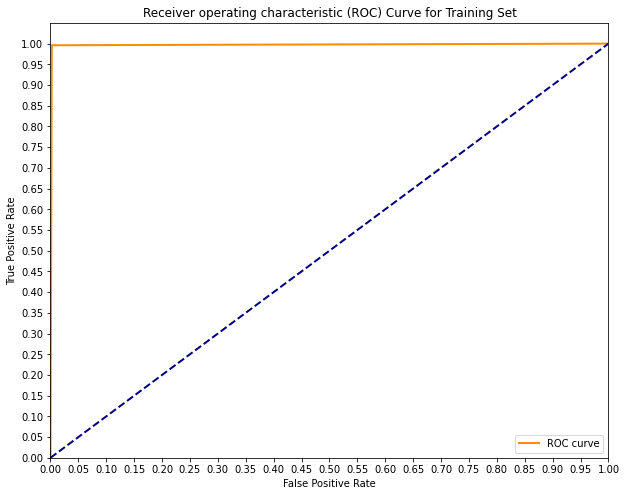

In [192]:
# ROC curve for testing set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Testing AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
plt.show()

In [220]:
# Interpret this
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)
print('classification report:\n ', classification_report(y_test, y_hat_test))

Confusion Matrix:
 [[10231    25]
 [    2   508]]
classification report:
                precision    recall  f1-score   support

           0       1.00      1.00      1.00     10256
           1       0.95      1.00      0.97       510

    accuracy                           1.00     10766
   macro avg       0.98      1.00      0.99     10766
weighted avg       1.00      1.00      1.00     10766



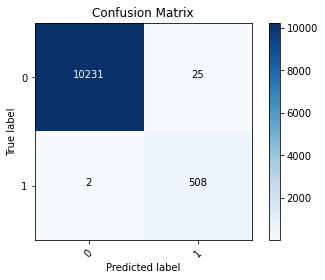

In [186]:
# Create the basic matrix
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(y) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

### Build a Model with Only the Best Features

In [169]:

best_mod.feature_importances_

array([1.05062656e-05, 2.95711358e-01, 0.00000000e+00, 2.52681535e-05,
       3.67645985e-02, 0.00000000e+00, 4.00793542e-08, 3.85361194e-06,
       3.56741521e-07, 2.40359456e-07, 2.45887875e-07, 6.67464675e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.49285708e-05,
       1.86333658e-07, 3.05492703e-07, 0.00000000e+00, 6.72390658e-08,
       1.51638118e-07, 6.16092899e-08, 5.50840247e-08, 0.00000000e+00,
       7.42696938e-08, 1.33482122e-07, 1.51731794e-07, 0.00000000e+00,
       1.16694513e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.77855407e-07, 8.29653058e-07, 7.58699393e-07, 5.59558947e-07,
       0.00000000e+00, 0.00000000e+00])

In [203]:
def plot_feature_importances(model, X_train):
    feature_importances = model.feature_importances_
    features = X_train.columns
    plt.bar(features, feature_importances)
    plt.xlabel("Feature Names")
    plt.ylabel("Feature Importance\nScores")
    plt.title("Feature Importances\nBar Chart")
    plt.xticks(rotation=85)
    plt.show()

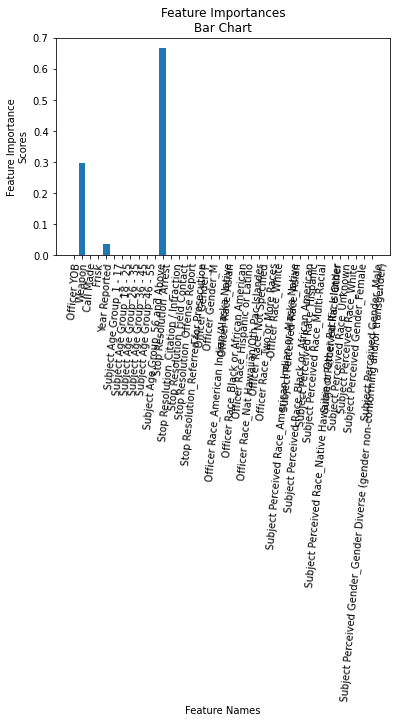

In [204]:
plot_feature_importances(model=best_mod, X_train=X_train_all)


In [214]:
best_feats = ['Weapon', 'Year Reported', 'Stop Resolution_Arrest']
X_feat_train = X_train_all[best_feats]
X_feat_test = X_test_all[best_feats]

In [215]:
# Check for class imbalance
print(y_train.value_counts())

# Fit SMOTE to training data
smote = SMOTE()
X_feat_resampled, y_feat_resampled = smote.fit_sample(X_feat_train, y_train)

# Preview synthtic sample class distrubution
print('\n')
print(pd.Series(y_feat_resampled).value_counts())

0    30634
1     1663
Name: Arrest Made, dtype: int64


1    30634
0    30634
dtype: int64


In [217]:
best_mod.fit(X_feat_resampled, y_feat_resampled)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [218]:
y_hat_feat = best_mod.predict(X_feat_test)

In [219]:
best_mod.score(X_feat_test, y_test) # R^2 Score 

0.9976778747910088

In [227]:
fpr, tpr, thresh = roc_curve(y_test, y_hat_feat)
rocauc = auc(fpr, tpr)

# print('Training Root Mean Square Error', np.sqrt(mean_squared_error(y_resampled_train, y_scores)))
print('Testing Root Mean Square Error', np.sqrt(mean_squared_error(y_test, y_hat_feat)))
print('Test FPR: ', fpr)
print('Test TPR: ', tpr)
print('Test ROC AUC Score: ', rocauc)

Testing Root Mean Square Error 0.048188434390331346
Test FPR:  [0.        0.0024376 1.       ]
Test TPR:  [0. 1. 1.]
Test ROC AUC Score:  0.9987812012480499


Testing AUC: 0.9987812012480499


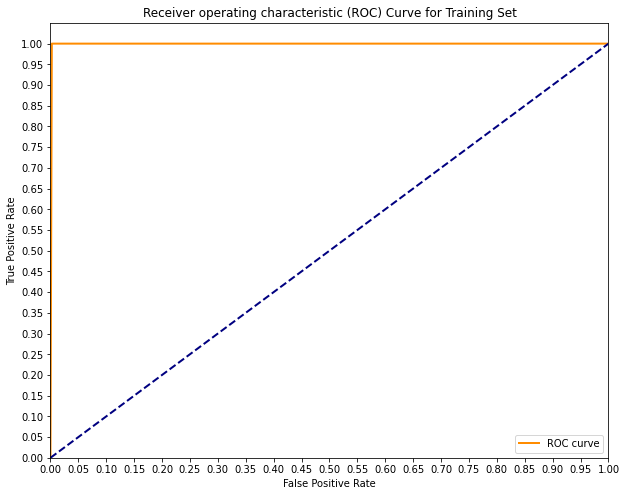

In [228]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Testing AUC: {}'.format(auc(fpr, tpr)))
plt.show()